# Applied Data Science Capstone Project (Week 2)  

# Which city has the Best Nightlife? 
## Las Vegas? Miami? New York City? 


## Table of contents
* [Introduction: Tourist Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction

Millions of people love to travel and explore new places all over the world.  

Before they plan their trip. Most of the tourists will try to look for the best places to stay, dine, party, etc.  

We all know **Las Vegas**, **New York City**, and **Miami** are the most attractive tourist destinations among others in the USA. Each place is unique and known for its attraction.

**The entertainment capital of the world** LAS VEGAS is known for its gambling, shopping, fine dining, entertainment, and nightlife. The major attraction in Las Vegas are the casinos and the hotels and each casino have its nightclubs. 

**The city that never sleeps** NEW YORK is known for many Broadway theaters, cinemas, and electronic billboards and nightlife. It has one of the world's most famous bars, music clubs, and night clubs. 

**Miami** South Beach is home to some of the most beautiful beaches and outstanding nightclubs in the country. 
The city attracts the second-highest number of foreign tourists of any city in the United States, after New York City.

Let's help a tourist who is a NightOwl (Nightlife Lover) and curious to know which city has the best **Nightlife** among these three cities? 

## Data

To address this,  We have to know the definition of Nightlife and what categories come under this Nightlife.
For this project, we will be considering the below factors(features).
* Venue Ratings 
* Venue Prices
* Venue Likes
* Venue Tips

We will be narrowing our search for within 5 miles radius from the center of the City.

Following data sources will be needed to extract/generate the required data:
* Cities Lat and Long values will be obtained using Google Maps API reverse geocoding.
* Venues and its details will be obtained using Foursquare API.

**Note:** We will be evaluating our results with *Top 10 values* from each nightlife category for each city. We also restrict our data collection for up to 50 records for each category.

### Importing Required Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('All Libraries imported.')

All Libraries imported.


In [216]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20200427' # Foursquare API version

In [3]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION)

In [4]:
results = requests.get(url).json()

In [5]:
category_json = results['response']['categories'][4]['categories']


### List of Nightlife categories

In [6]:
capture_categories = []
def get_categories(json):
    for row in json:
        if not row['categories']:
            capture_categories.append([row['id'],row['name']])
            #print(row['id'],row['name'])
        else:
            get_categories(row['categories'])
            #print(row['categories'])
    return capture_categories
    
categories = pd.DataFrame(get_categories(category_json),columns=['id','category'])
categories

,id,category
0,52e81612bcbc57f1066b7a0d,Beach Bar
1,56aa371ce4b08b9a8d57356c,Beer Bar
2,4bf58dd8d48988d117941735,Beer Garden
3,52e81612bcbc57f1066b7a0e,Champagne Bar
4,4bf58dd8d48988d11e941735,Cocktail Bar
5,4bf58dd8d48988d118941735,Dive Bar
6,4bf58dd8d48988d1d8941735,Gay Bar
7,4bf58dd8d48988d119941735,Hookah Bar
8,4bf58dd8d48988d1d5941735,Hotel Bar
9,4bf58dd8d48988d120941735,Karaoke Bar


In [7]:
# Function takes the city name and gives back lat and lng values.
def get_lat_lon(city):
    address = city
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude



In [8]:
NY_lat_lon = get_lat_lon('New York City,NY')
NY_lat = NY_lat_lon[0]
NY_lon = NY_lat_lon[1]

In [9]:
# Function to produce the intial venue data based on lat,lng,categoryid
def get_venue_data(lat,lan,catId,category,state):
    categoryId = catId
    sortByPopularity = 1
    limit = 50
    radius = 8047 # 5 miles radius
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}&sortByPopularity={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        lan, 
        VERSION, 
        categoryId,
        radius, 
        limit,
        sortByPopularity)
    
    result = requests.get(url).json()
    
    df = pd.json_normalize(result['response']['groups'][0]['items'])
    
    fil_cols = ['venue.id','venue.name', 'venue.location.address','venue.location.lat', 'venue.location.lng'
                ,'venue.location.city','venue.location.state','venue.categories']
    df = df[fil_cols]
    rename_cols = [x.split('.')[-1] for x in df.columns.values]
    # rename columns
    df.columns = rename_cols
    # get category name
    df.iloc[:,-1]=df.iloc[:,-1].apply(lambda x:x[0]['name'])
    

    # Filtering the categories (Even though we passed category id as paramter. Foursquare api produced data related to 
    # other categories.Applying filters to filter the data and sticking to its own state.)
    cat = category
    df = df[(df['state']==state) & (df['categories']==cat)]
    
    return df
    


### NY Nightlife categories

In [10]:
NY_data = []
for category_id,category_desc in categories.values.tolist():
    print(category_desc)
    try:
        data = get_venue_data(NY_lat,NY_lon,category_id,category_desc,'NY')
        NY_data.append(data)
    except:
        print('{} not found'.format(category_desc))

NY = pd.concat(NY_data,ignore_index=True)
NY







Beach Bar
Beer Bar
Beer Garden
Champagne Bar
Cocktail Bar
Dive Bar
Gay Bar
Hookah Bar
Hotel Bar
Karaoke Bar
Pub
Sake Bar
Speakeasy
Sports Bar
Tiki Bar
Whisky Bar
Wine Bar
Brewery
Lounge
Night Market
Nightclub
Other Nightlife
Strip Club


,id,name,address,lat,lng,city,state,categories
0,4f107e84e5e852ca73ddd2fa,Brooklyn Crab,24 Reed St,40.675319,-74.016540,Brooklyn,NY,Beach Bar
1,5939980d7269fe615663d2c1,Harold's Surf Shack,231 Hudson St,40.724402,-74.007840,New York,NY,Beach Bar
2,4de2874dc65b7a3e211ca1ba,Tiki Disco!,272 Meserole St,40.705026,-73.933712,Brooklyn,NY,Beach Bar
3,54060cfa498ee012568144af,Sonia's Salty Seniorita,507 E 12th St,40.729070,-73.980721,New York,NY,Beach Bar
4,45c84eb8f964a5206b421fe3,The Perfect Pint,123 W 45th St,40.757275,-73.983857,New York,NY,Beer Bar
...,...,...,...,...,...,...,...,...
510,4b5be6ebf964a520771c29e3,Peep world,151 33rd,40.750186,-73.990717,New York,NY,Strip Club
511,3fd66200f964a520c8e51ee3,The VIP Club for Adult Entertainment NYC,20 W 20th St,40.740322,-73.992477,New York,NY,Strip Club
512,4bf883fd4a67c928ee9825cf,Hunkamania,515 W 27th St,40.751221,-74.004433,New York,NY,Strip Club
513,4e9118381081927c31a3c16d,Escobar Lounge,77 7th Ave,40.738898,-73.999459,New York,NY,Strip Club


### NY Nightlife category record counts (grouped).

In [11]:
NY['categories'].value_counts()

Wine Bar         44
Cocktail Bar     40
Hookah Bar       38
Strip Club       36
Gay Bar          35
Whisky Bar       33
Sports Bar       32
Beer Garden      29
Speakeasy        28
Sake Bar         27
Pub              26
Dive Bar         24
Karaoke Bar      24
Beer Bar         20
Nightclub        20
Lounge           17
Brewery          14
Tiki Bar         13
Hotel Bar         5
Beach Bar         4
Night Market      4
Champagne Bar     2
Name: categories, dtype: int64

### Miami Nightlife categories

In [12]:
Miami_lat_lon = get_lat_lon('Miami,FL')
Miami_lat = Miami_lat_lon[0]
Miami_lon = Miami_lat_lon[1]

Miami_data = []
for category_id,category_desc in categories.values.tolist():
    print(category_desc)
    try:
        data = get_venue_data(Miami_lat,Miami_lon,category_id,category_desc,'FL')
        Miami_data.append(data)
    except:
        print('{} not found'.format(category_desc))

Miami = pd.concat(Miami_data,ignore_index=True)
Miami

Beach Bar
Beer Bar
Beer Garden
Champagne Bar
Champagne Bar not found
Cocktail Bar
Dive Bar
Gay Bar
Hookah Bar
Hotel Bar
Karaoke Bar
Pub
Sake Bar
Speakeasy
Sports Bar
Tiki Bar
Whisky Bar
Wine Bar
Brewery
Lounge
Night Market
Night Market not found
Nightclub
Other Nightlife
Strip Club


,id,name,address,lat,lng,city,state,categories
0,4b948b28f964a520f57c34e3,Nikki Beach Miami,1 Ocean Dr,25.768786,-80.132058,Miami Beach,FL,Beach Bar
1,5a18d78b1ffed7595e60bdad,Palace Bar,1052 Ocean Dr,25.781233,-80.130512,Miami Beach,FL,Beach Bar
2,423e0e80f964a52058201fe3,Caffe Milano,850 Ocean Dr,25.778939,-80.131033,Miami Beach,FL,Beach Bar
3,535821a7498e96aa68bf23be,Sugar Factory (Miami),1144 Ocean Dr,25.782540,-80.130254,Miami Beach,FL,Beach Bar
4,57e14474498ec5198b847bbe,Mendez Fuel,3201 Coral Way,25.750462,-80.246757,Coral Gables,FL,Beer Bar
...,...,...,...,...,...,...,...,...
237,4b2c944ff964a520eec724e3,Playmates Club,3875 Shipping Ave,25.733318,-80.257378,Miami,FL,Strip Club
238,40e0b100f964a5206c041fe3,Club Madonna,1527 Washington Ave,25.788140,-80.131698,Miami Beach,FL,Strip Club
239,4f03b9140039115d817390df,Miami City Girls,18205 Biscayne Blvd,25.769963,-80.192041,North Miami,FL,Strip Club
240,4ee7dd012c5bba516ce09567,Rachel's Steakhouse and Cabaret,NaN,25.775918,-80.133670,Miami Beach,FL,Strip Club


### Miami Nightlife category record counts (grouped).

In [13]:
Miami['categories'].value_counts()

Nightclub       46
Wine Bar        30
Sports Bar      27
Cocktail Bar    20
Hookah Bar      15
Pub             14
Lounge          14
Beer Garden     10
Speakeasy       10
Brewery          8
Hotel Bar        8
Dive Bar         7
Gay Bar          6
Karaoke Bar      6
Strip Club       6
Beer Bar         5
Beach Bar        4
Whisky Bar       4
Tiki Bar         1
Sake Bar         1
Name: categories, dtype: int64

### Vegas Nightlife categories

In [14]:
Vegas_lat_lon = get_lat_lon('Vegas,NV')
Vegas_lat = Vegas_lat_lon[0]
Vegas_lon = Vegas_lat_lon[1]

Vegas_data = []
for category_id,category_desc in categories.values.tolist():
    print(category_desc)
    try:
        data = get_venue_data(Vegas_lat,Vegas_lon,category_id,category_desc,'NV')
        Vegas_data.append(data)
    except:
        print('{} not found'.format(category_desc))

Vegas = pd.concat(Vegas_data,ignore_index=True)
Vegas

Beach Bar
Beer Bar
Beer Garden
Champagne Bar
Cocktail Bar
Dive Bar
Gay Bar
Hookah Bar
Hotel Bar
Karaoke Bar
Pub
Sake Bar
Speakeasy
Sports Bar
Tiki Bar
Whisky Bar
Wine Bar
Brewery
Lounge
Night Market
Night Market not found
Nightclub
Other Nightlife
Strip Club


,id,name,address,lat,lng,city,state,categories
0,5bcfdb094940bc002c382de5,Land Shark Lookout,NaN,36.116512,-115.170900,Las Vegas,NV,Beach Bar
1,58cf192a6ad5a131a78953c4,Island Pub,NaN,36.124287,-115.172198,Paradise,NV,Beach Bar
2,54322028498e1a4f9088843e,Tao Beach,NaN,36.123130,-115.170438,Paradise,NV,Beach Bar
3,53d423c1498e87e25197a992,The GIN Bar of Azul Fives Hotel,La Riviera maya,36.135567,-115.162010,Q Roo,NV,Beach Bar
4,540b35e9498ec23df39bd1cf,monte carlo cabana #7,NaN,36.105784,-115.176598,Paradise,NV,Beach Bar
...,...,...,...,...,...,...,...,...
307,41326e00f964a52036141fe3,Foxy Girls,3013 S Highland Dr,36.135207,-115.174861,Las Vegas,NV,Strip Club
308,4c940b5201dd76b06d7fb448,Bunnies of Las Vegas,3135 Industrial Rd Ste 212,36.135399,-115.170507,Las Vegas,NV,Strip Club
309,4ba582f2f964a520140e39e3,Diamond Cabaret,3177 S Highland Dr,36.132457,-115.176658,Las Vegas,NV,Strip Club
310,4e4d2e821fc7bd85f5ecc429,Night School 4 Girls,3850 Las Vegas Blvd S,36.098517,-115.176280,Las Vegas,NV,Strip Club


### Vegas Nightlife category record counts (grouped).

In [15]:
Vegas['categories'].value_counts()

Nightclub          35
Sports Bar         35
Strip Club         26
Dive Bar           26
Pub                22
Hotel Bar          20
Brewery            18
Cocktail Bar       18
Beer Garden        14
Lounge             14
Speakeasy          14
Gay Bar            13
Karaoke Bar        13
Hookah Bar         10
Wine Bar           10
Beer Bar            6
Beach Bar           5
Whisky Bar          4
Tiki Bar            4
Sake Bar            3
Champagne Bar       1
Other Nightlife     1
Name: categories, dtype: int64

As we noticed, couple of categories has very few record counts. Let us consider only those categories which has at least 10 records.

In [16]:
Miami_set = set(Miami['categories'].value_counts()[Miami['categories'].value_counts()>10].index.values)

In [17]:
Vegas_set = set(Vegas['categories'].value_counts()[Vegas['categories'].value_counts()>10].index.values)

In [18]:
NY_set = set(NY['categories'].value_counts()[NY['categories'].value_counts()>10].index.values)

Lets find the categories which are common in all three cities.

In [203]:
fil_categories = list(NY_set.intersection(Vegas_set,Miami_set))
fil_categories

['Nightclub', 'Pub', 'Lounge', 'Cocktail Bar', 'Sports Bar']

In [21]:
M = Miami[Miami.categories.isin(fil_categories)]['categories'].value_counts()

In [22]:
V = Vegas[Vegas.categories.isin(fil_categories)]['categories'].value_counts()

In [23]:
N = NY[NY.categories.isin(fil_categories)]['categories'].value_counts()

In [24]:
cols = M.index.values.tolist()
Nightlife_stats = pd.DataFrame([M.values,V.values,N.values],columns=cols,index=['Miami','Vegas','NY'])

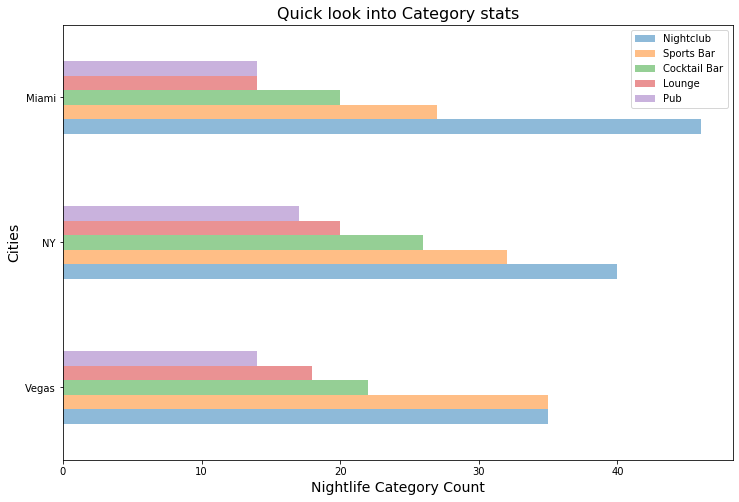

In [205]:
%matplotlib inline
Nightlife_stats.sort_values('Nightclub').plot(kind='barh',figsize=(12,8),alpha=0.5)
plt.xlabel('Nightlife Category Count',fontsize=14)
plt.ylabel('Cities',fontsize=14)
plt.title('Quick look into Category stats',fontsize=16)
plt.show()

As we noticed, different categories have different counts. To be consistent let us get top 25 records for each category. Once we have further venue details like ratings etc. We will be sorting the data and narrow it down to top 10.

In [26]:
Miami_category_filtered = Miami[Miami['categories'].isin(fil_categories)].groupby('categories').head(25)[['id', 'name','lat', 'lng', 'city','state','categories']]

In [27]:
Vegas_category_filtered = Vegas[Vegas['categories'].isin(fil_categories)].groupby('categories').head(25)[['id', 'name','lat', 'lng', 'city','state', 'categories']]

In [28]:
NY_category_filtered = NY[NY['categories'].isin(fil_categories)].groupby('categories').head(25)[['id', 'name','lat', 'lng', 'city','state', 'categories']]

In [29]:
Vegas_category_filtered

,id,name,lat,lng,city,state,categories
26,4d0144ba6212721ea500e011,The Chandelier,36.109475,-115.173501,Las Vegas,NV,Cocktail Bar
27,586776c9f5957273256c396e,The Dorsey,36.122231,-115.170430,Las Vegas,NV,Cocktail Bar
28,4fda3875e4b02f685e771630,Bar 46,36.170719,-115.144544,Las Vegas,NV,Cocktail Bar
29,56ea4ff1498eba4b1eb2a462,The Still,36.121391,-115.175272,Las Vegas,NV,Cocktail Bar
30,4b933bdaf964a5208b3c34e3,Phil’s Italian Steak House,36.124209,-115.172173,Las Vegas,NV,Cocktail Bar
...,...,...,...,...,...,...,...
270,49de85bef964a52069601fe3,LAVO Italian Restaurant & Nightclub,36.124404,-115.169382,Las Vegas,NV,Nightclub
271,4c5778b2b7a31b8dc07c50da,Aria SkySuite Lounge,36.108554,-115.178104,Las Vegas,NV,Nightclub
272,49de8976f964a5206e601fe3,The Rockhouse,36.122500,-115.171007,Las Vegas,NV,Nightclub
273,5c1dbc2e1c0b34002c88a8cb,On The Record,36.104892,-115.174535,Las Vegas,NV,Nightclub


In [30]:
NY_category_filtered

,id,name,lat,lng,city,state,categories
55,50bcb93ae4b0efcb4c84d434,The Dead Rabbit,40.703051,-74.010992,New York,NY,Cocktail Bar
56,57196183498efeaaa4043f3c,Dutch Fred's,40.760700,-73.987914,New York,NY,Cocktail Bar
57,4c9a999d292a6dcb7871d076,Riverpark,40.739803,-73.973459,New York,NY,Cocktail Bar
58,4dc34fc7ae608779d1064ae9,Bathtub Gin,40.743638,-74.003290,New York,NY,Cocktail Bar
59,54f276c5498e7a6fbeb24115,Tanner Smiths,40.764486,-73.981652,New York,NY,Cocktail Bar
...,...,...,...,...,...,...,...
474,3fd66200f964a520f2e61ee3,The Monster,40.733522,-74.002508,New York,NY,Nightclub
475,51603739e4b0a9d70ee7fe34,Comedy Cellar at The Village Underground,40.730792,-74.000846,New York,NY,Nightclub
476,4e0bcf1f45dd496ab442f888,The Cutting Room,40.745986,-73.982801,New York,NY,Nightclub
477,4c8d901155fba093997669ab,Bedlam,40.721866,-73.980485,New York,NY,Nightclub


In [206]:
Miami_category_filtered

,id,name,lat,lng,city,state,categories
19,4af6f0bef964a5203e0422e3,Mango's Tropical Cafe,25.779351,-80.130978,Miami Beach,FL,Cocktail Bar
20,4f21ea32e4b05183c96b76f8,The Broken Shaker,25.804369,-80.126288,Miami Beach,FL,Cocktail Bar
21,55fef511498ecbc151fc3f6e,American Social,25.767836,-80.196240,Miami,FL,Cocktail Bar
22,40e5f700f964a520090a1fe3,The Playwright Irish Pub & Restaurant,25.784139,-80.131997,Miami Beach,FL,Cocktail Bar
23,55fed742498eb466f6578517,Sweet Liberty Drink & Supply Co.,25.796032,-80.129744,Miami Beach,FL,Cocktail Bar
...,...,...,...,...,...,...,...
210,5b7c200892e7a9002c1175a4,Centro Wynwood,25.799715,-80.209303,Miami,FL,Nightclub
211,5ac0fc858b98fd444435f1dd,The 5Th Base,25.778202,-80.220985,Miami,FL,Nightclub
212,564e752c498e340b55544f08,Rockwell Miami,25.777863,-80.133035,Miami Beach,FL,Nightclub
213,40e0b100f964a5204a051fe3,Space 34,25.784714,-80.192734,Miami,FL,Nightclub


In [208]:
Vegas_venue_ids = Vegas_category_filtered['id'].values.tolist()
Miami_venue_ids = Miami_category_filtered['id'].values.tolist()
NY_venue_ids = NY_category_filtered['id'].values.tolist()

In [39]:
print('We have {} venue ids'.format(len(Vegas_venue_ids+Miami_venue_ids+NY_venue_ids)))


We have 314 venue ids


In [207]:
Miami_category_filtered[Miami_category_filtered.name.str.contains('Mango')]

,id,name,lat,lng,city,state,categories
19,4af6f0bef964a5203e0422e3,Mango's Tropical Cafe,25.779351,-80.130978,Miami Beach,FL,Cocktail Bar
191,4af6f0bef964a5203e0422e3,Mango's Tropical Cafe,25.779351,-80.130978,Miami Beach,FL,Nightclub


We noticed couple of venue id's has multiple categories like shown above. As, we can only make 500 premium calls/day. Let us get the unique venue ids.

In [49]:
print('We have {} unique venue ids'.format(len(set(Vegas_venue_ids+Miami_venue_ids+NY_venue_ids))))

We have 292 unique venue ids


In [48]:
# Function checks if a particular venue detail is missing. It will assign 0 value to it.
def check_column(std_cols,df):
    df_col = set(df.columns.values.tolist())
    missing_columns = set(std_cols).difference(df_col)
    #print(missing_columns)
    
    if len(missing_columns)>0:
        for c in missing_columns:
            df[c] = 0
    return df

In [ ]:
# Code to get further venue details like rating, likes, tips, price, hours, etc
Venue_ids = pd.DataFrame(list(set(Vegas_venue_ids+Miami_venue_ids+NY_venue_ids)),columns=['venue_id'])
#print('We have {} venues'.format(len(Venue_ids)))

# venue standard details columns we about to extract
standard_columns = ['venue.id', 'venue.name','venue.price.tier','venue.price.message'
                        ,'venue.likes.count','venue.rating','venue.tips.count','venue.popular.timeframes']
# Dataframe where we store the Venue details information
Venue_details_df = pd.DataFrame(columns=standard_columns)
Venue_details_df['venue.id'] = Venue_ids['venue_id']
for row in np.arange(Venue_details_df.shape[0]):
    venue_id = Venue_details_df.iloc[row,0]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    venue_result = requests.get(url).json()
    V_details_raw = pd.json_normalize(venue_result['response'])
    try:
        Venue_details_df.iloc[row,1:] = V_details_raw[standard_columns].iloc[0,1:]
    except:
        new_Venue_details_raw = check_column(standard_columns,V_details_raw)
        Venue_details_df.iloc[row,1:] = new_Venue_details_raw[standard_columns].iloc[0,1:]



In [209]:
filtered_V_details_df = Venue_details_df[(Venue_details_df['venue.rating']>0)&(Venue_details_df['venue.price.message']!=0)]

In [52]:
def get_weekend_hrs(day):
    hours = []
    weekdays = [a['days'] for a in x if a['days']!='Today']
    for r in x:
        if r['days'] in weekdays:
            hours.append([r['days'],r['open'][0]['renderedTime']])
        else:
            missing = list(set(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']).difference(weekdays))[0]
            hours.append([missing,r['open'][0]['renderedTime']])
    return [hrs[1] for hrs in hours if hrs[0]==day][0]

In [54]:
#filtered_V_details_df['Fri_hrs'] = filtered_V_details_df['venue.popular.timeframes'].apply(lambda x:get_weekend_hrs('Fri'))
#filtered_V_details_df['Sat_hrs'] = filtered_V_details_df['venue.popular.timeframes'].apply(lambda x:get_weekend_hrs('Sat'))
#filtered_V_details_df['Sun_hrs'] = filtered_V_details_df['venue.popular.timeframes'].apply(lambda x:get_weekend_hrs('Sun'))

### Checking datatypes of further venue details

In [210]:
filtered_V_details_df.dtypes

venue.id                    object
venue.name                  object
venue.price.tier            object
venue.price.message         object
venue.likes.count           object
venue.rating                object
venue.tips.count            object
venue.popular.timeframes    object
dtype: object

In [58]:
#We noticed the weekend (Fri, Sat, Sun) hours are same for all venues across three cities. So lets drop the hours.
filtered_V_details_df = filtered_V_details_df.drop('venue.popular.timeframes',1)

In [59]:
# converting datatypes
filtered_V_details_df['venue.price.tier'] = filtered_V_details_df['venue.price.tier'].astype(int)
filtered_V_details_df['venue.likes.count'] = filtered_V_details_df['venue.likes.count'].astype(int)
filtered_V_details_df['venue.rating'] = filtered_V_details_df['venue.rating'].astype(float)
filtered_V_details_df['venue.tips.count'] = filtered_V_details_df['venue.tips.count'].astype(int)

Before merging the venue details to the first part of data. Lets take a look at the data below.

In [60]:
filtered_V_details_df.head()

,venue.id,venue.name,venue.price.tier,venue.price.message,venue.likes.count,venue.rating,venue.tips.count
0,547ec4fc498e110589f46917,Basement,3,Expensive,73,7.2,16
1,4b2c9a88f964a52014c824e3,Four Kegs Sports Pub,2,Moderate,54,8.0,42
3,4b1b0c64f964a5201ff723e3,Maxine's Bistro & Bar,2,Moderate,214,6.4,121
4,4e7f894f00394ee73103f4ef,No Fun,2,Moderate,294,6.7,106
5,4b2c87aaf964a520a3c724e3,WALL Miami,3,Expensive,118,7.6,45


In [212]:
Vegas_Final_df = Vegas_category_filtered.merge(filtered_V_details_df,left_on='id',right_on='venue.id')
#Vegas_Final_df.head()

Vegas final data set with more venue details (rating,likes,tips,price etc)

In [62]:
Vegas_Final_df.drop('venue.id',1,inplace=True)
Vegas_Final_df.drop('venue.name',1,inplace=True)
Vegas_Final_df.rename(columns={'venue.price.tier':'price_tier','venue.price.message':'price_range','venue.likes.count':'likes','venue.rating':'rating','venue.tips.count':'tips'},inplace=True)
Vegas_Final_df.head()

,id,name,lat,lng,city,state,categories,price_tier,price_range,likes,rating,tips
0,4d0144ba6212721ea500e011,The Chandelier,36.109475,-115.173501,Las Vegas,NV,Cocktail Bar,2,Moderate,1036,8.3,307
1,4d0144ba6212721ea500e011,The Chandelier,36.109475,-115.173501,Las Vegas,NV,Lounge,2,Moderate,1036,8.3,307
2,586776c9f5957273256c396e,The Dorsey,36.122231,-115.170430,Las Vegas,NV,Cocktail Bar,3,Expensive,79,7.4,12
3,4fda3875e4b02f685e771630,Bar 46,36.170719,-115.144544,Las Vegas,NV,Cocktail Bar,2,Moderate,17,6.7,4
4,56ea4ff1498eba4b1eb2a462,The Still,36.121391,-115.175272,Las Vegas,NV,Cocktail Bar,1,Cheap,39,6.9,8


In [63]:
Vegas_Final_df['categories'].value_counts()

Nightclub       22
Sports Bar      19
Pub             16
Cocktail Bar    15
Lounge          14
Name: categories, dtype: int64

NY final data set with more venue details (ratings,likes,tips,prices etc)

In [64]:
NY_Final_df = NY_category_filtered.merge(filtered_V_details_df,left_on='id',right_on='venue.id')
NY_Final_df.drop('venue.id',1,inplace=True)
NY_Final_df.drop('venue.name',1,inplace=True)
NY_Final_df.rename(columns={'venue.price.tier':'price_tier','venue.price.message':'price_range','venue.likes.count':'likes','venue.rating':'rating','venue.tips.count':'tips'},inplace=True)
NY_Final_df.head()

,id,name,lat,lng,city,state,categories,price_tier,price_range,likes,rating,tips
0,50bcb93ae4b0efcb4c84d434,The Dead Rabbit,40.703051,-74.010992,New York,NY,Cocktail Bar,3,Expensive,2047,9.0,477
1,57196183498efeaaa4043f3c,Dutch Fred's,40.760700,-73.987914,New York,NY,Cocktail Bar,3,Expensive,209,8.2,39
2,4c9a999d292a6dcb7871d076,Riverpark,40.739803,-73.973459,New York,NY,Cocktail Bar,3,Expensive,346,8.8,125
3,4dc34fc7ae608779d1064ae9,Bathtub Gin,40.743638,-74.003290,New York,NY,Cocktail Bar,3,Expensive,1244,8.6,311
4,54f276c5498e7a6fbeb24115,Tanner Smiths,40.764486,-73.981652,New York,NY,Cocktail Bar,3,Expensive,604,8.5,85


In [65]:
NY_Final_df['categories'].value_counts()

Pub             25
Sports Bar      24
Cocktail Bar    24
Nightclub       17
Lounge          16
Name: categories, dtype: int64

Miami final data set with more venue details (ratings,likes,tips,prices etc)

In [66]:
Miami_Final_df = Miami_category_filtered.merge(filtered_V_details_df,left_on='id',right_on='venue.id')
Miami_Final_df.drop('venue.id',1,inplace=True)
Miami_Final_df.drop('venue.name',1,inplace=True)
Miami_Final_df.rename(columns={'venue.price.tier':'price_tier','venue.price.message':'price_range','venue.likes.count':'likes','venue.rating':'rating','venue.tips.count':'tips'},inplace=True)
Miami_Final_df.head()

,id,name,lat,lng,city,state,categories,price_tier,price_range,likes,rating,tips
0,4af6f0bef964a5203e0422e3,Mango's Tropical Cafe,25.779351,-80.130978,Miami Beach,FL,Cocktail Bar,2,Moderate,1134,7.9,297
1,4af6f0bef964a5203e0422e3,Mango's Tropical Cafe,25.779351,-80.130978,Miami Beach,FL,Nightclub,2,Moderate,1134,7.9,297
2,4f21ea32e4b05183c96b76f8,The Broken Shaker,25.804369,-80.126288,Miami Beach,FL,Cocktail Bar,2,Moderate,1042,9.2,231
3,55fef511498ecbc151fc3f6e,American Social,25.767836,-80.196240,Miami,FL,Cocktail Bar,1,Cheap,28,5.0,32
4,55fef511498ecbc151fc3f6e,American Social,25.767836,-80.196240,Miami,FL,Sports Bar,1,Cheap,28,5.0,32


In [67]:
Miami_Final_df['categories'].value_counts()

Nightclub       19
Sports Bar      19
Cocktail Bar    16
Lounge          13
Pub             10
Name: categories, dtype: int64

In [68]:
# Top 10 records for each Category
Miami_top10 = Miami_Final_df.sort_values(['categories','rating'],ascending=[True,False]).groupby('categories').head(10)
Vegas_top10 = Vegas_Final_df.sort_values(['categories','rating'],ascending=[True,False]).groupby('categories').head(10)
NY_top10 = NY_Final_df.sort_values(['categories','rating'],ascending=[True,False]).groupby('categories').head(10)

In [213]:
# Hot encodig the categorical data.
final_columns = ['name','price_range','likes','rating','tips','categories']
Miami_hot = pd.get_dummies(Miami_top10[final_columns].set_index(['name','categories']))
Vegas_hot = pd.get_dummies(Vegas_top10[final_columns].set_index(['name','categories']))
NY_hot = pd.get_dummies(NY_top10[final_columns].set_index(['name','categories']))
Vegas_hot.head()

,,likes,rating,tips,price_range_Cheap,price_range_Expensive,price_range_Moderate,price_range_Very Expensive
name,categories,,,,,,,
BARDOT Brasserie,Cocktail Bar,157,8.6,37,0,1,0,0
The Chandelier,Cocktail Bar,1036,8.3,307,0,0,1,0
Caesars Palace Diamond VIP Lounge,Cocktail Bar,82,8.3,27,0,1,0,0
Phil’s Italian Steak House,Cocktail Bar,20,8.1,10,0,0,1,0
Baccarat Bar,Cocktail Bar,71,7.8,20,0,1,0,0


In [70]:
# As we see different numbers for each column. Lets Normalize the fields.
normalize_columns = ['rating','likes','tips']
def normalize_data(df_name,col_list):
    for col in col_list:
        df_name.loc[:,col] = df_name[col]/df_name[col].max()
    return df_name

NY_hot = normalize_data(NY_hot,['rating', 'likes', 'tips'])
Miami_hot = normalize_data(Miami_hot,['rating', 'likes', 'tips'])
Vegas_hot = normalize_data(Vegas_hot,['rating', 'likes', 'tips'])

C:\Users\thamats\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [71]:
NY_norm = NY_hot.reset_index().set_index('name').groupby('categories').mean()

In [72]:
Miami_norm = Miami_hot.reset_index().set_index('name').groupby('categories').mean()

In [215]:
Vegas_norm = Vegas_hot.reset_index().set_index('name').groupby('categories').mean()
Vegas_norm.head()

,likes,rating,tips,price_range_Cheap,price_range_Expensive,price_range_Moderate,price_range_Very Expensive
categories,,,,,,,
Cocktail Bar,184.6,7.84,57.2,0.0,0.7,0.3,0.0
Lounge,411.2,8.08,135.9,0.0,0.6,0.3,0.1
Nightclub,616.1,8.36,106.3,0.1,0.3,0.1,0.5
Pub,58.9,7.51,25.6,0.5,0.0,0.5,0.0
Sports Bar,123.2,7.61,33.8,0.4,0.0,0.6,0.0


In [74]:
NY_norm['place']='NY'
Miami_norm['place']='Miami'
Vegas_norm['place']='Vegas'

In [75]:
final_frame = [NY_norm,Miami_norm,Vegas_norm]
final_df = pd.concat(final_frame).rename(columns={'price_range_Cheap':'Cheap','price_range_Expensive':'Expensive'
                                                  ,'price_range_Moderate':'Moderate'
                                                  ,'price_range_Very Expensive':'VeryExpensive'})

### Final Dataframe which we will be using to examine the results.

In [76]:
final_df.reset_index().groupby(['place','categories']).mean()

likes    rating      tips  Cheap  Expensive  Moderate  \
place categories                                                               
Miami Cocktail Bar  0.454586  0.913043  0.465657    0.1        0.1       0.7   
      Lounge        0.275661  0.891304  0.283502    0.1        0.3       0.5   
      Nightclub     0.280952  0.903261  0.227273    0.0        0.5       0.3   
      Pub           0.138889  0.822826  0.201347    0.2        0.0       0.8   
      Sports Bar    0.161640  0.828261  0.248822    0.3        0.0       0.7   
NY    Cocktail Bar  0.318267  0.957609  0.318056    0.0        0.8       0.1   
      Lounge        0.452157  0.923913  0.531528    0.0        0.7       0.3   
      Nightclub     0.227872  0.878261  0.162500    0.1        0.4       0.2   
      Pub           0.191591  0.839130  0.229583    0.3        0.2       0.5   
      Sports Bar    0.098985  0.794565  0.110972    0.4        0.1       0.5   
Vegas Cocktail Bar  0.119097  0.825263  0.171772    0.0        0.7       0.3   
      Lounge        0.265290  0.850526  0.408108    0.0        0.6       0.3   
      Nightclub     0.397484  0.880000  0.319219    0.1        0.3       0.1   
      Pub           0.038000  0.790526  0.076877    0.5        0.0       0.5   
      Sports Bar    0.079484  0.801053  0.101502    0.4        0.0       0.6   

                    VeryExpensive  
place categories                   
Miami Cocktail Bar            0.1  
      Lounge                  0.1  
      Nightclub               0.2  
      Pub                     0.0  
      Sports Bar              0.0  
NY    Cocktail Bar            0.1  
      Lounge                  0.0  
      Nightclub               0.3  
      Pub                     0.0  
      Sports Bar              0.0  
Vegas Cocktail Bar            0.0  
      Lounge                  0.1  
      Nightclub               0.5  
      Pub                     0.0  
      Sports Bar              0.0

## Methodoloy

In this project, we will confine our efforts to the Nightlife categories suggested by Foursquare API, and the venues within 5 miles radius from the center of the city. Here in the final step, we deal with the **Top 10 records** from each category for each city.

In step one, we obtained the nightlife categories suggested by the Foursquare API. Later, we filtered the nightlife categories which are common across different cities. For these filtered categories, we gathered the **data: name, Lat, Lng, id of the venue for each category within 5 miles of radius** using FourSquare API. We limited our search for up to 50 records for each category.

In step two, we went ahead to get more details about each venue like **ratings, prices, likes, tips** bypassing the venue ids. After grouping the records based on the categories, we noticed different value counts for each group. To get accurate results, we decided to go with the top 10 records from each category. Repeat these steps for each city.

In step three, we **Hot Encode** any categorical data. In our case its the **price_range** column. Once we hot encode the price column, we normalize the data because data varies within a different range of numbers. After normalizing the data, we merge the data related to these three cities into a final data frame and obtained the mean values shown above.

## Analysis

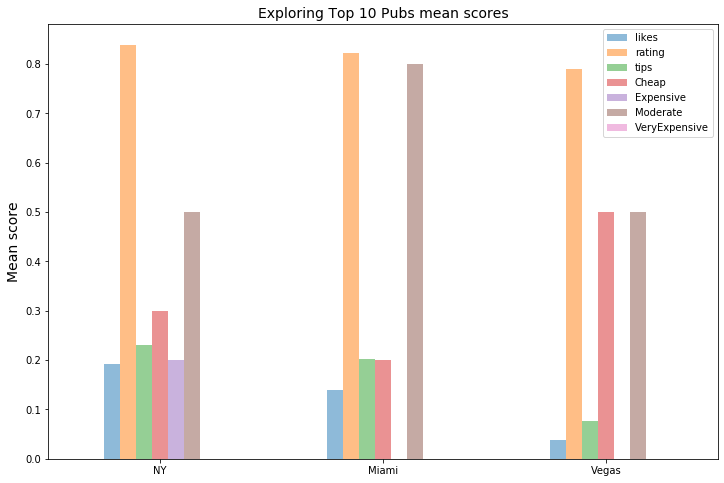

In [90]:
final_df = final_df.reset_index()
final_df[final_df['categories']=='Pub'].set_index('place').plot(kind='bar',rot=0,alpha=0.5,
                                                                                                 figsize=(12,8))
plt.title('Exploring Top 10 Pubs mean scores',fontsize=14)
plt.ylabel('Mean score',fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('');


The above chart shows NY has the best Pubs ratings.

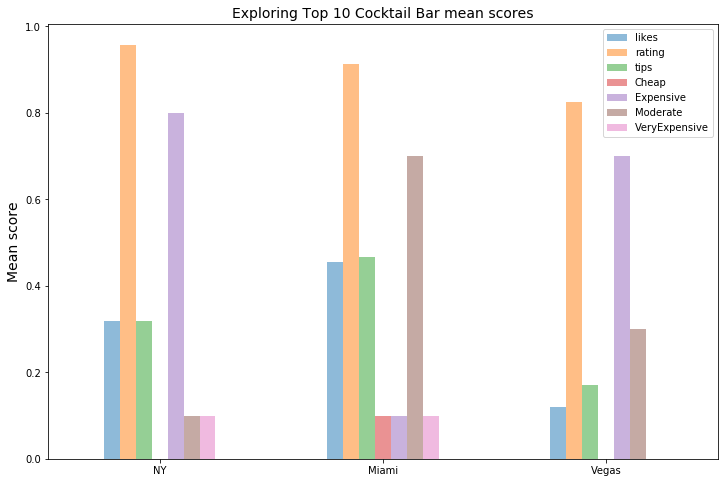

In [91]:
final_df[final_df['categories']=='Cocktail Bar'].set_index('place').plot(kind='bar',rot=0,alpha=0.5,
                                                                                                 figsize=(12,8))
plt.title('Exploring Top 10 Cocktail Bar mean scores',fontsize=14)
plt.ylabel('Mean score',fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('');


The above chart shows NY has the best Cocktail Bars ratings.

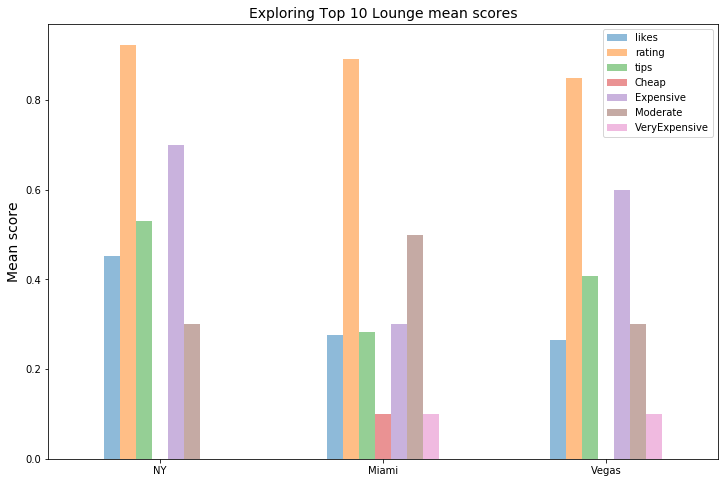

In [92]:
final_df[final_df['categories']=='Lounge'].set_index('place').plot(kind='bar',rot=0,alpha=0.5,
                                                                                                 figsize=(12,8))
plt.title('Exploring Top 10 Lounge mean scores',fontsize=14)
plt.ylabel('Mean score',fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('');


The above chart shows NY has the best Lounges ratings.

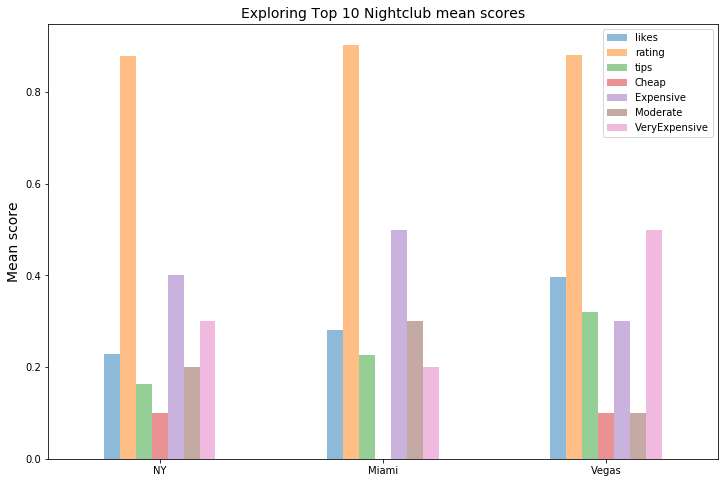

In [93]:
final_df[final_df['categories']=='Nightclub'].set_index('place').plot(kind='bar',rot=0,alpha=0.5,
                                                                                                 figsize=(12,8))
plt.title('Exploring Top 10 Nightclub mean scores',fontsize=14)
plt.ylabel('Mean score',fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('');


The above chart shows Miami Nightclubs has the best ratings.

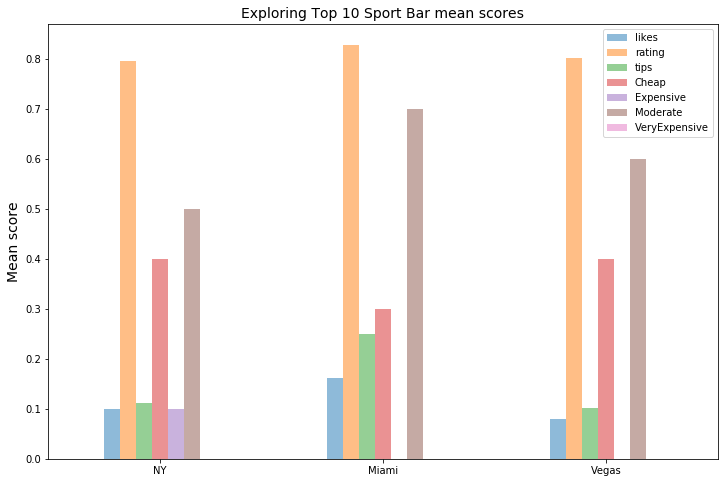

In [94]:
final_df[final_df['categories']=='Sports Bar'].set_index('place').plot(kind='bar',rot=0,alpha=0.5,
                                                                                                 figsize=(12,8))
plt.title('Exploring Top 10 Sport Bar mean scores',fontsize=14)
plt.ylabel('Mean score',fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('');


The above chart shows Miami has best the Sport Bars ratings.

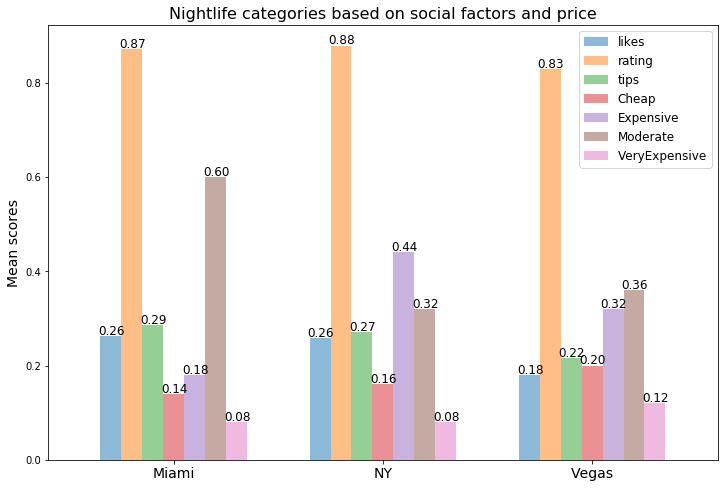

In [199]:
xticks = ['Miami','NY','Vegas']
ax = final_df.groupby('place').mean().plot(kind='bar',figsize=(12,8),alpha=0.5,rot=0,width=0.7)

for p in ax.patches:
    value = '{:.2f}'.format(p.get_height())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.11
    y=p.get_y()+height+0.003
    ax.annotate(value,(x,y),fontsize=12)

ax.set_title('Nightlife categories based on social factors and price',fontsize=16)
ax.set_ylabel('Mean scores',fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(xticks,fontsize=14)
ax.legend(fontsize=12);




Based on the above chart.**NY** Nightlife categories got the best rating. Where as **Miami** secured most tips.  
**Vegas** has the most **Very expensive** as well as **less expensive** nightlife options compared to **Miami and NY**.  


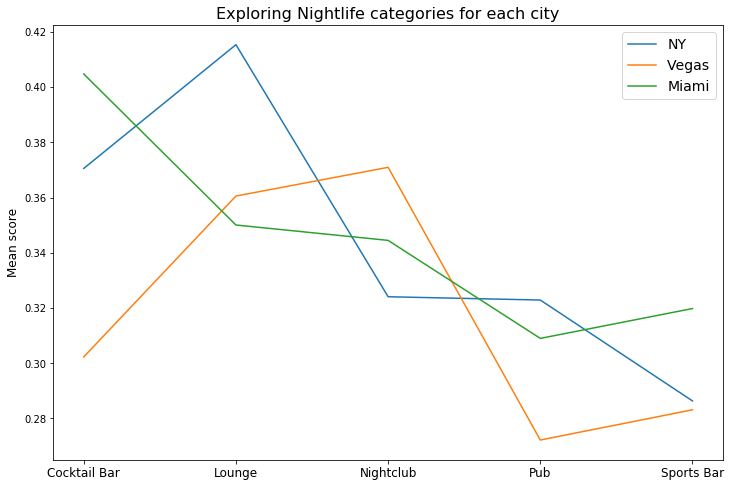

In [187]:
xtics = final_df['categories'].unique().tolist()
ax = final_df[final_df.place=='NY'].set_index('categories').mean(1).plot(figsize=(12,8))
final_df[final_df.place=='Vegas'].set_index('categories').mean(1).plot(axes=ax)
final_df[final_df.place=='Miami'].set_index('categories').mean(1).plot(axes=ax)
ax.set_xlabel('')
plt.xticks(np.arange(5), (xticks),fontsize=12)
plt.legend(['NY','Vegas','Miami'],fontsize=14);
ax.set_title('Exploring Nightlife categories for each city',fontsize=16)
ax.set_ylabel('Mean score',fontsize=12);




Based on the above chart. It is evident that 
- **NY** has best Lounges and Pubs
- **Miami** has best Cocktail Bars and Sport Bars
- **Vegas** has best Nightclubs


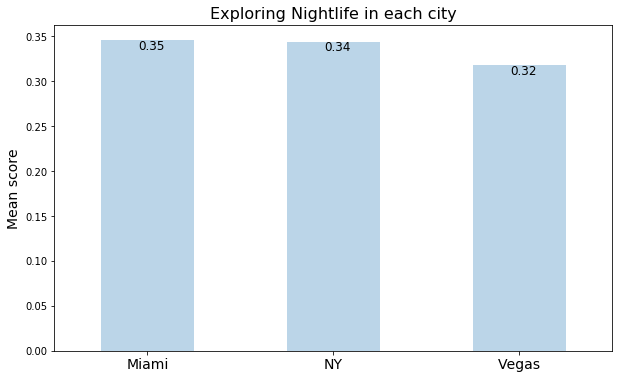

In [188]:
xticks=['Miami','NY','Vegas']
ax = final_df.groupby('place').mean().mean(1).plot(kind='bar',figsize=(10,6),alpha=0.3,rot=0)
for p in ax.patches:
    value = '{:.2f}'.format(p.get_height())
    width,height = p.get_width(),p.get_height()
    x=p.get_x()+width-0.3
    y=p.get_y()+height-0.01
    ax.annotate(value,(x,y),fontsize=12)
    
ax.set_title('Exploring Nightlife in each city',fontsize=16)
ax.set_ylabel('Mean score',fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(xticks,fontsize=14);


Though **Miami and NY** has much similar mean scores for Nightlife categories but data shows **Miami** has the **best nightlife** compared to **NY and Vegas**.

## Result and Discussion

We analyzed the five Nightlife categories **(Sport Bars, Pubs, Nightclubs, Cocktail Bars and Lounges)**. We considered social factors like ratings, likes, tips and prices for our analysis.

Based on the analysis, we found **NY** has the best *ratings*, **Miami** secured best *tips* and **Vegas** received minimum likes for their nightlife venues.  
**Vegas** has both **very expensive** and **less expensive** nightlife options.
It is interesting to notice that people in **Miami and NY** gave equal *likes* to their nightlife venues.

Based on the Data. We also observed:
- **NY** has best *Lounges and Pubs*
- **Miami** has best *Cocktail Bars and Sport Bars*
- **Vegas** has best *Nightclubs*

## Conclusion

Although **Miami and NY** has much similar mean scores for Nightlife categories. Which indicates both cities have similar Nightlife. But, based on the data **Miami** has the **best nightlife** compared to **NY and Vegas**.